     |████████████████████████████████| 384 kB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 249 kB/s  eta 0:00:01
     |████████████████████████████████| 647 kB 80.7 MB/s eta 0:00:01
     |████████████████████████████████| 889 kB 87.4 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 1.3 MB/s  eta 0:00:01
     |████████████████████████████████| 273 kB 75.3 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 355 kB/s  eta 0:00:01
     |████████████████████████████████| 66 kB 4.6 MB/s  eta 0:00:01
     |████████████████████████████████| 191 kB 67.3 MB/s eta 0:00:01
     |████████████████████████████████| 248 kB 87.6 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 4.8 MB/s  eta 0:00:01
     |████████████████████████████████| 97 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 842 kB/s  eta 0:00:01
     |████████████████████████████████| 5.6 MB 26.6 MB/s eta 0:00:01
     |████████████████████████████████| 51

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s


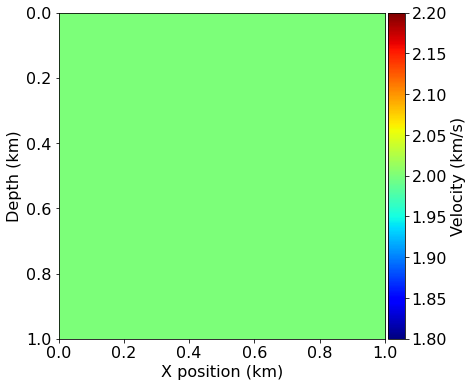

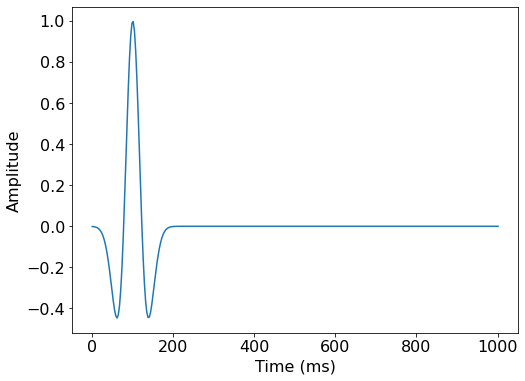

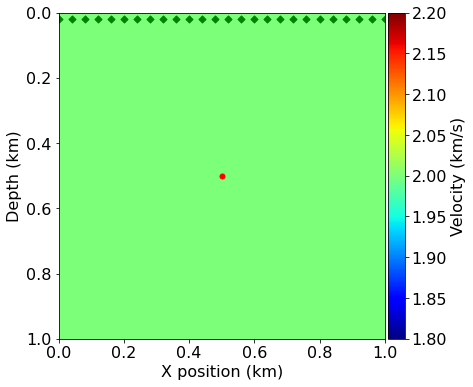

(328, 121, 121)
(328, 1)


Operator `Kernel` run in 0.01 s


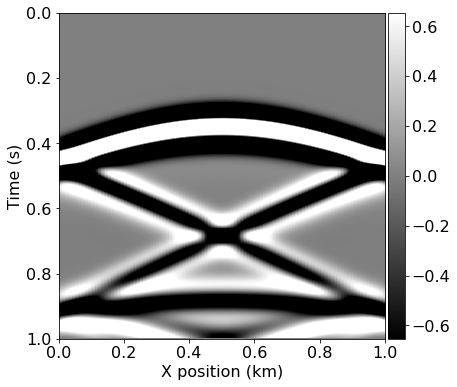

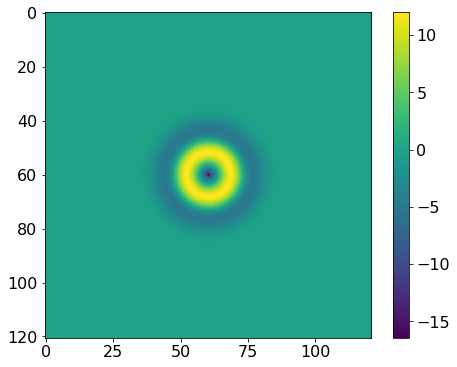

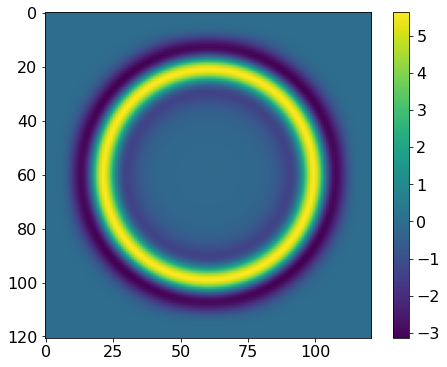

In [1]:
## FD part
!pip install devito
import numpy as np
import matplotlib.pyplot as plt
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 2.0
v[:, 51:] = 2.0

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)
mod_time_range = TimeAxis(start=t0, stop=tn, step=model.critical_dt)


#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = 500
src.coordinates.data[0, -1] = 500

# We can plot the time signature to see the wavelet
src.show()



#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2,save=mod_time_range.num)
print(u.shape)
print(src.shape)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde



# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)



#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

op(dt=model.critical_dt)

#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)
plt.imshow(u.data[50,:,:].T)
plt.colorbar()
plt.show()
plt.imshow(u.data[100,:,:].T)
plt.colorbar()
plt.show()


Num GPUs Available:  1


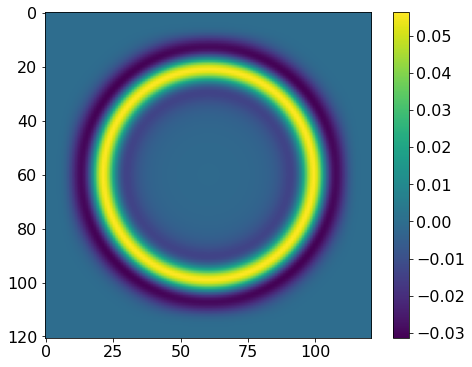

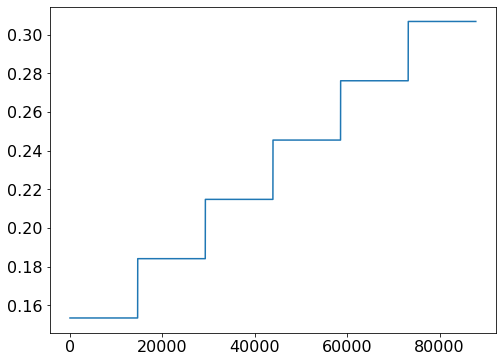

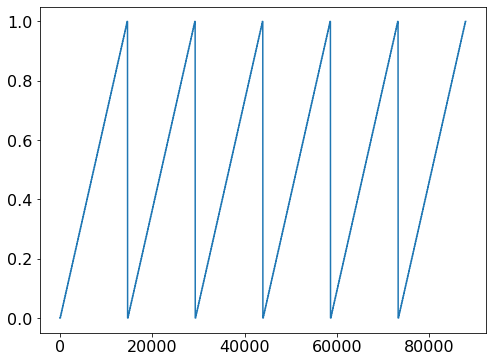

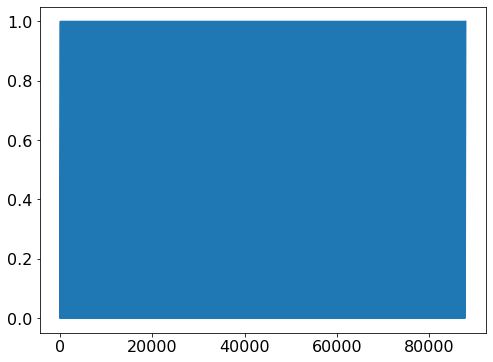

In [2]:
#PINN part
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

### PREPARE TRAINING DATA
t_ = time_range.time_values
t_ = np.arange(0, tn, dt)

x_ = np.arange(0, model.grid.extent[0]+model.grid.spacing[0], model.grid.spacing[0])
y_ = np.arange(0, model.grid.extent[1]+model.grid.spacing[1], model.grid.spacing[1])

tt, xx, yy = np.meshgrid(t_,x_, y_, indexing='ij')



u_bc=np.zeros(u.shape)

tt_bc=tt[50:101:10,:,:].reshape(-1,121,121)/np.max(tt)
xx_bc=xx[50:101:10,:,:].reshape(-1,121,121)/np.max(xx)
yy_bc=yy[50:101:10,:,:].reshape(-1,121,121)/np.max(yy)
u_bc=u.data[50:101:10,:,:].reshape(-1,121,121)/100

plt.imshow(u_bc[-1,...])
plt.colorbar()
plt.show()

tt=tt.reshape(-1,1)
xx=xx.reshape(-1,1)
yy=yy.reshape(-1,1)
tt_bc=tt_bc.reshape(-1,1)
xx_bc=xx_bc.reshape(-1,1)
yy_bc=yy_bc.reshape(-1,1)
u_bc=u_bc.reshape(-1,1)

xx_data = tf.data.Dataset.from_tensor_slices(xx_bc)
yy_data = tf.data.Dataset.from_tensor_slices(yy_bc)
tt_data = tf.data.Dataset.from_tensor_slices(tt_bc)
u_data = tf.data.Dataset.from_tensor_slices(u_bc)

xx_bc = xx_bc.astype(np.float32)
yy_bc = yy_bc.astype(np.float32)
tt_bc = tt_bc.astype(np.float32)

plt.plot(tt_bc)
plt.show()
plt.plot(xx_bc)
plt.show()
plt.plot(yy_bc)
plt.show()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_43 (Dense)             (None, 100)               400       
_________________________________________________________________
dense_44 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_46 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_47 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                

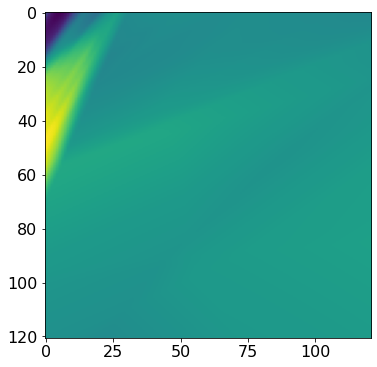

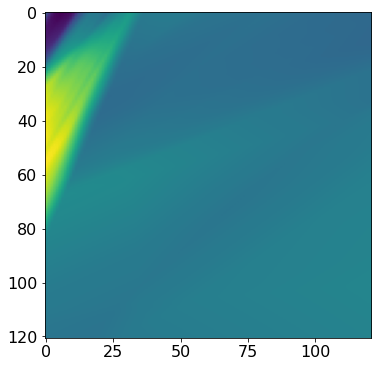

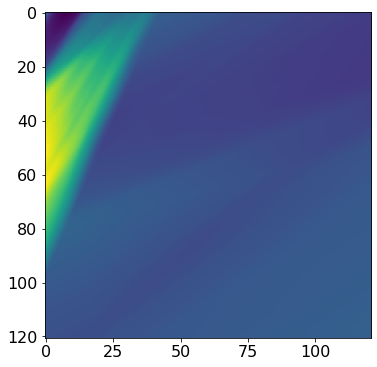

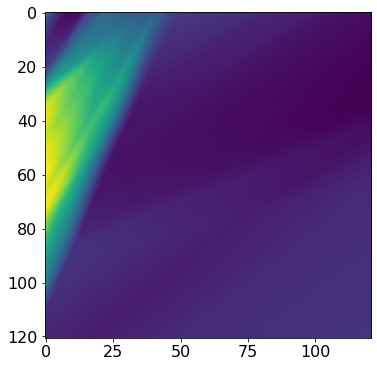

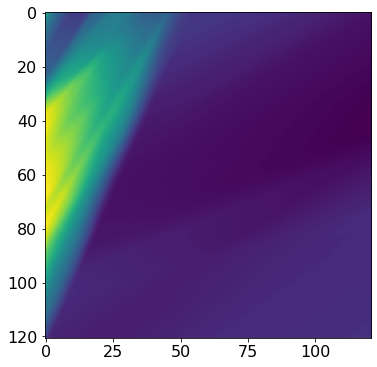

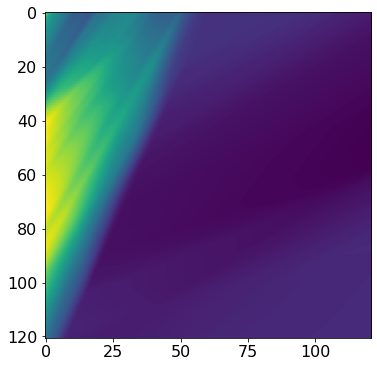

Epoch 500: Loss: 1.849e-04


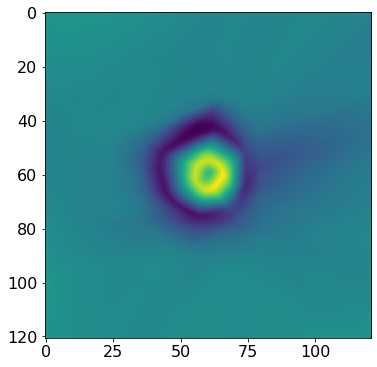

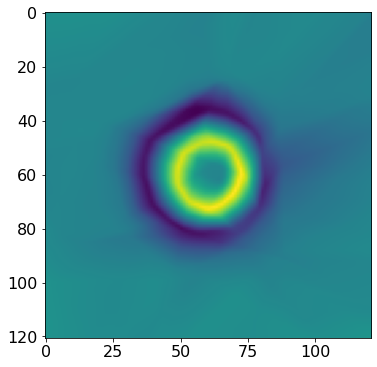

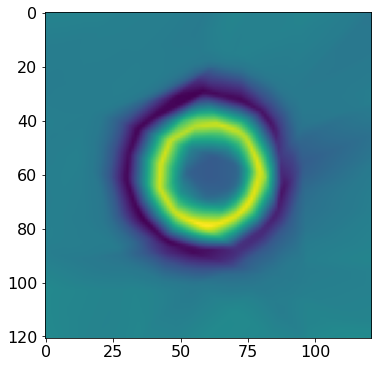

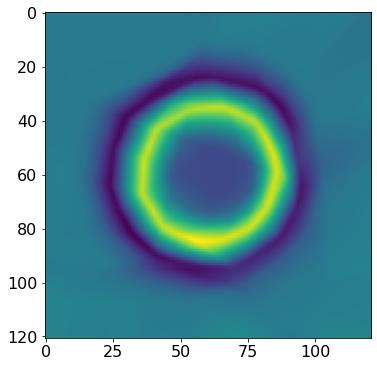

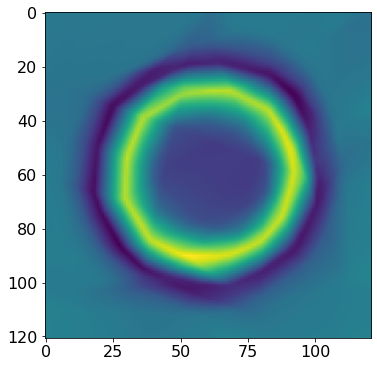

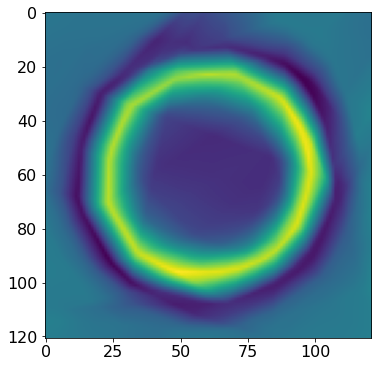

Epoch 1000: Loss: 8.542e-05


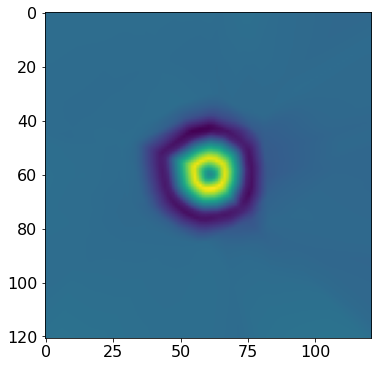

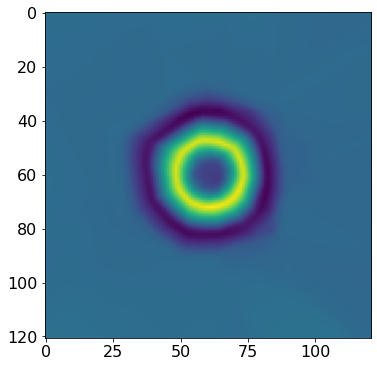

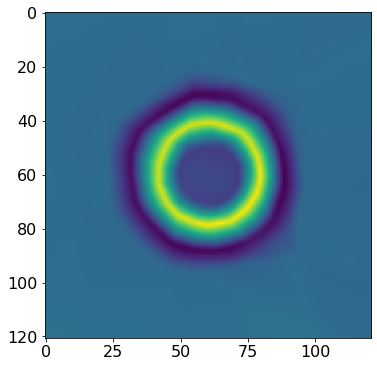

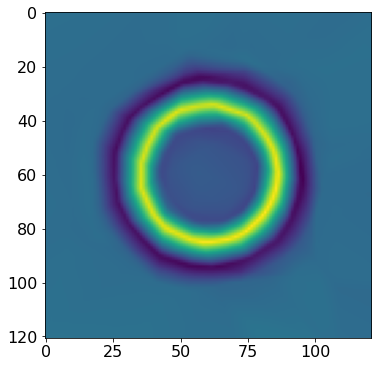

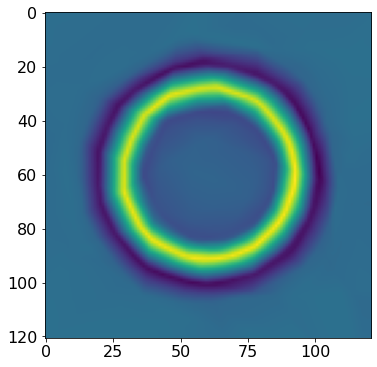

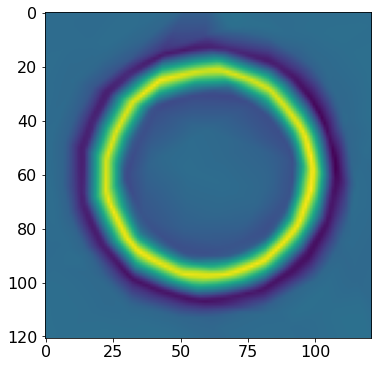

Epoch 1500: Loss: 4.341e-05


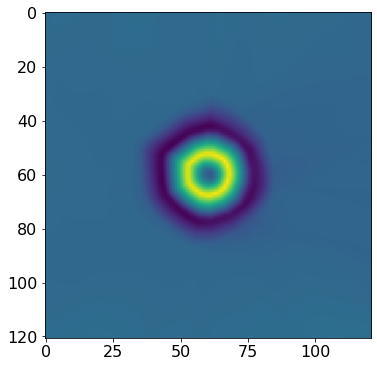

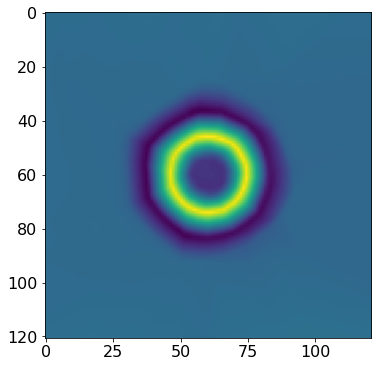

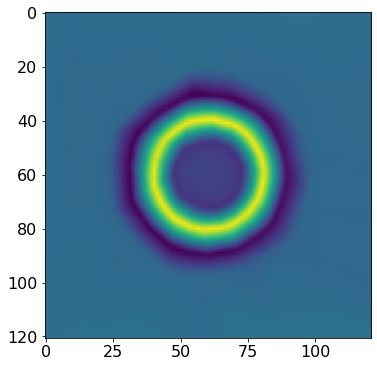

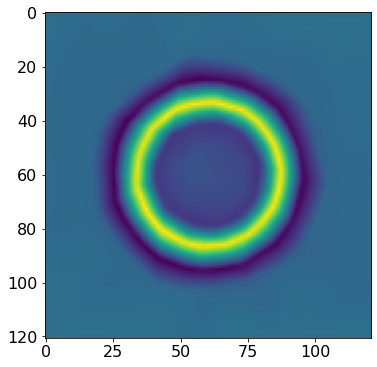

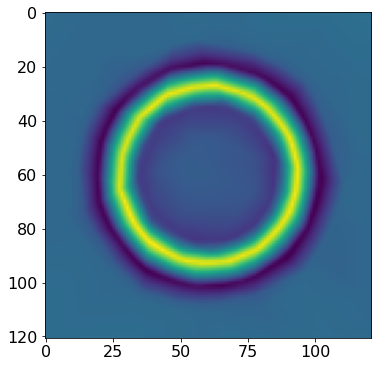

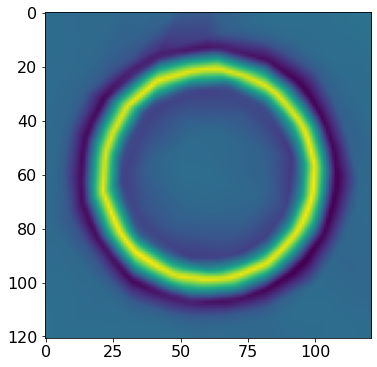

Epoch 2000: Loss: 6.720e-05


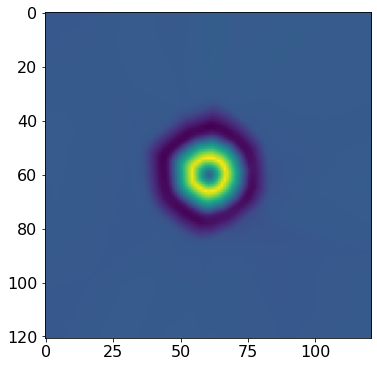

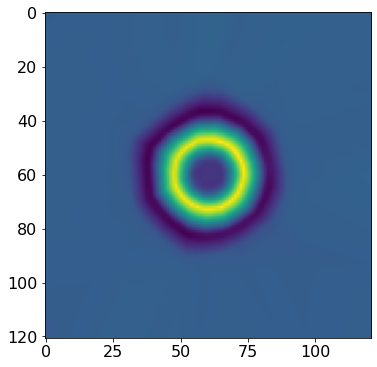

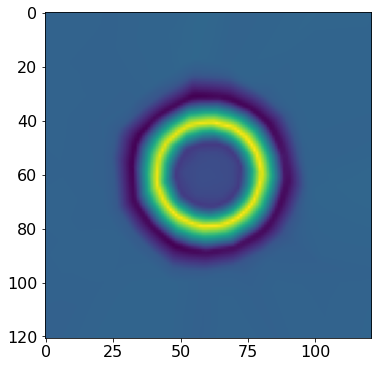

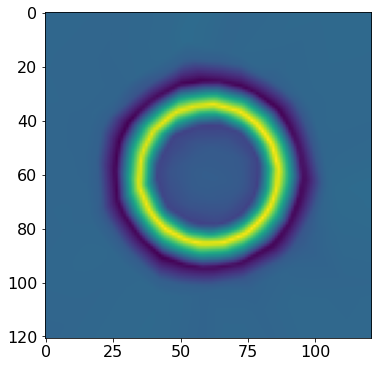

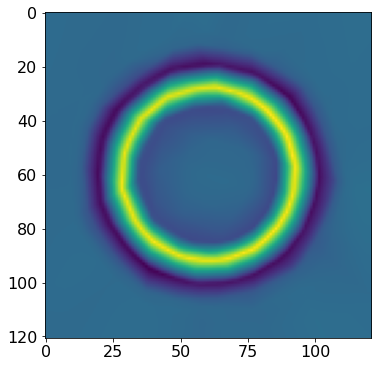

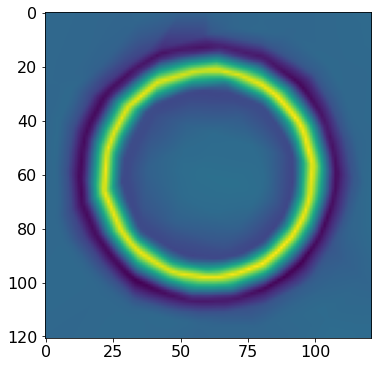

Epoch 2500: Loss: 7.059e-05


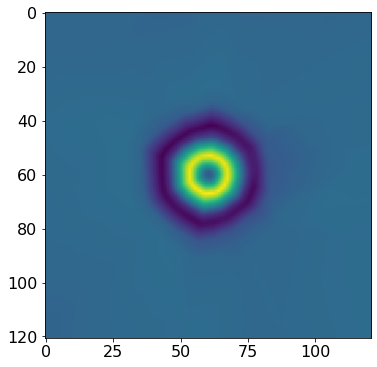

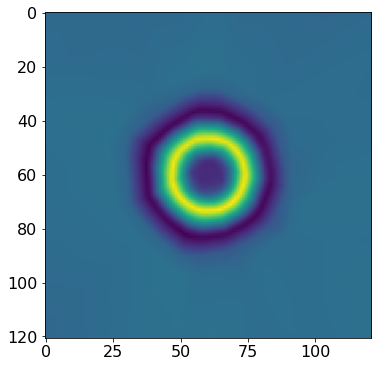

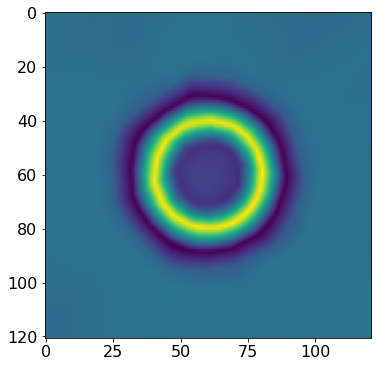

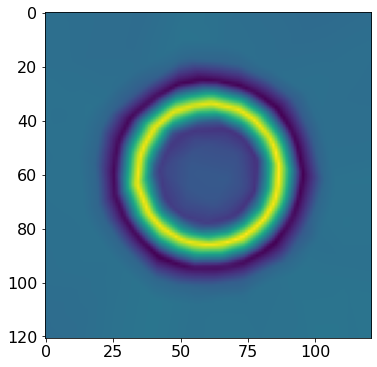

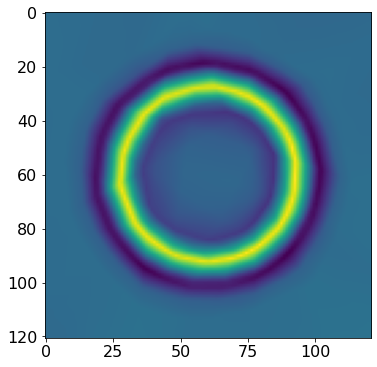

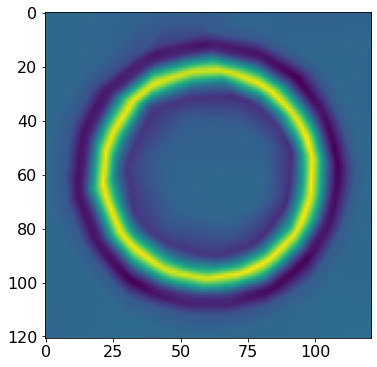

Epoch 3000: Loss: 5.596e-05


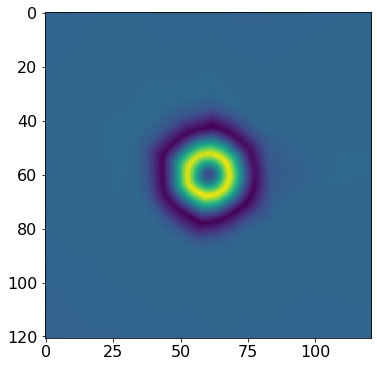

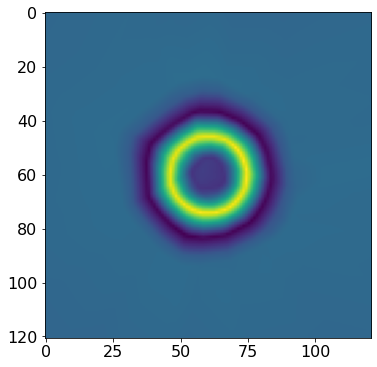

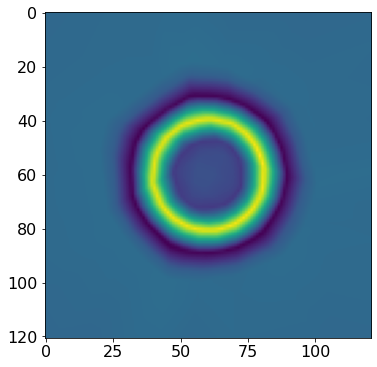

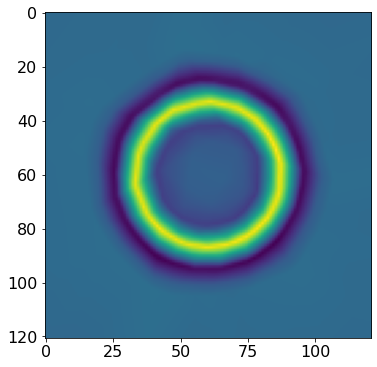

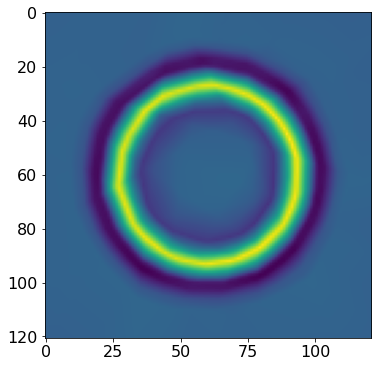

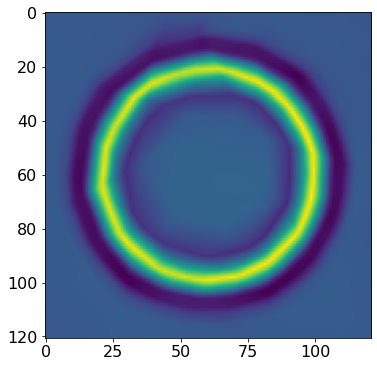

Epoch 3500: Loss: 3.204e-05


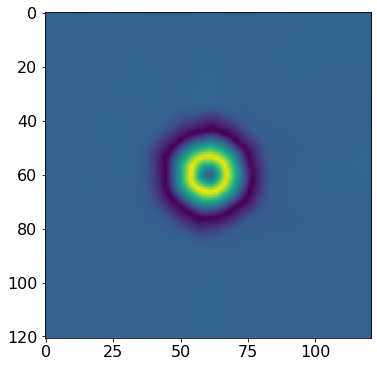

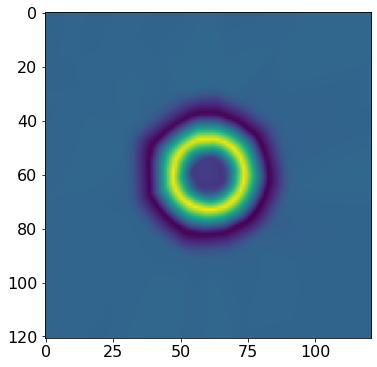

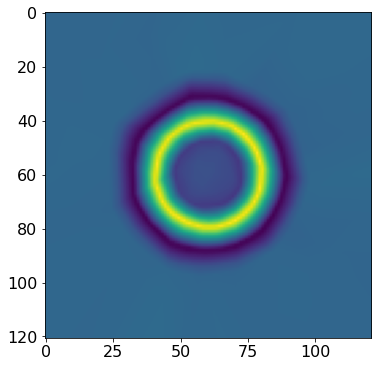

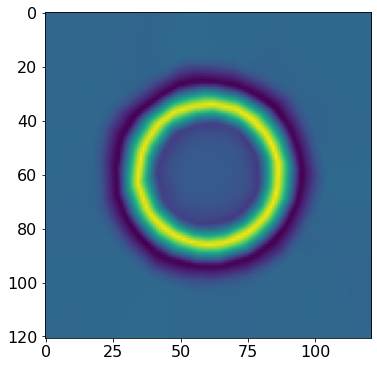

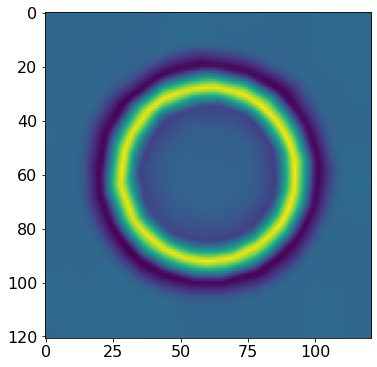

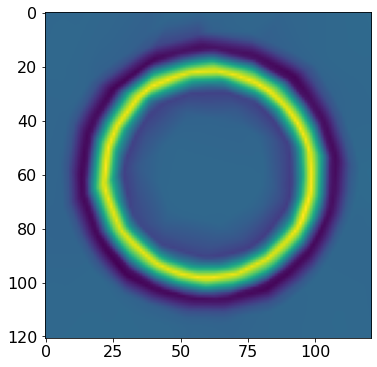

Epoch 4000: Loss: 7.331e-05


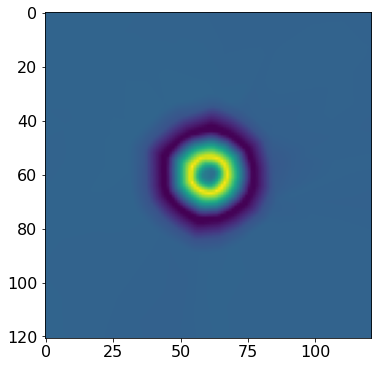

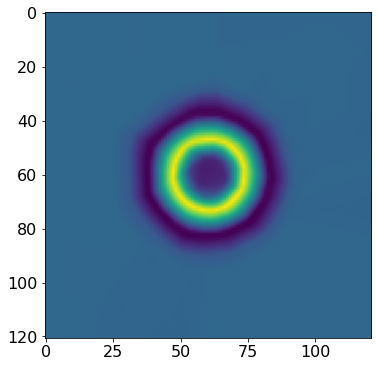

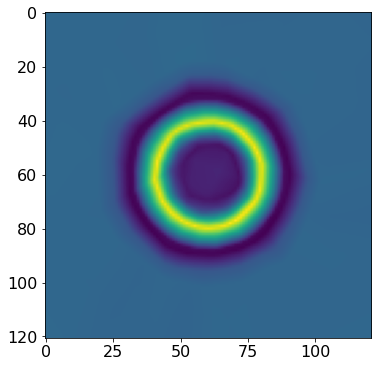

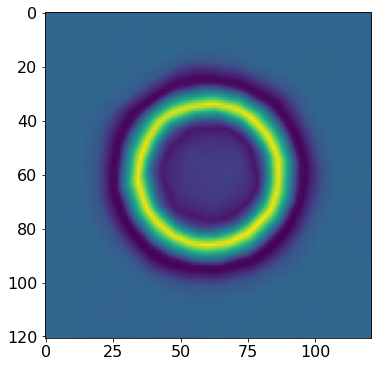

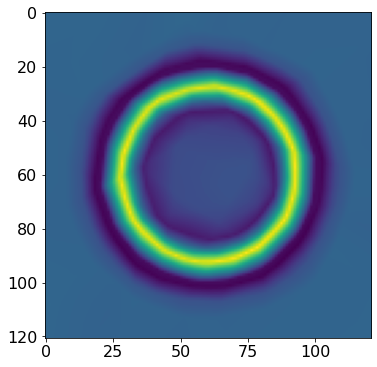

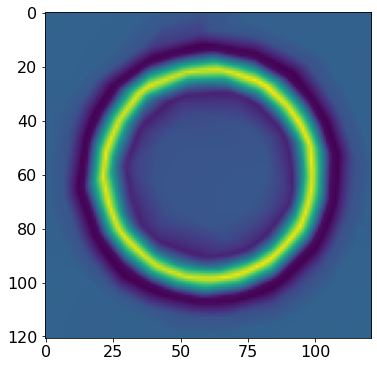

In [ ]:
act='tanh'
act2='relu'
nn_model = keras.Sequential(
    [
        layers.Dense(3, activation=act2,  input_shape=(3,)),
        layers.Dense(100, activation=act2),
        layers.Dense(100, activation=act2),
        layers.Dense(100, activation=act2),
        layers.Dense(10, activation=act),
        layers.Dense(10, activation=act),
        layers.Dense(1,activation="linear"),
    ]
)
#nn_model = keras.Sequential(
#    [
#        layers.Dense(3, activation="relu",  input_shape=(3,)),
#        layers.Dense(100, activation="relu"),
#        layers.Dense(100, activation="relu"),
#        layers.Dense(100, activation="relu"),
#        layers.Dense(100, activation="relu"),
#        layers.Dense(1,activation="linear"),
#    ]
#)

nn_model.summary()

@tf.function
def grad(nn_model,x,y,t,u):

   
    p = nn_model(tf.reshape(tf.concat([x,y,t],1),(-1,3)))

    p_x = tf.gradients(p, x)[0]
    p_xx= tf.gradients(p_x,x)[0]
    p_y = tf.gradients(p, y)[0]
    p_yy= tf.gradients(p_y,y)[0]
    p_t = tf.gradients(p, t)[0]
    p_tt= tf.gradients(p_t,t)[0]

    pde_model=p_xx+p_yy-p_tt/2/2
    bc_loss=tf.reduce_mean(tf.math.squared_difference(p,u))
    pde_loss=1000*tf.reduce_mean(pde_model*pde_model)
    total_loss=bc_loss+pde_loss

    return total_loss,bc_loss,pde_loss, tf.gradients(total_loss, nn_model.trainable_variables)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam()

dataset_=tf.concat((xx_bc,yy_bc,tt_bc,),1)
number_of_rows = dataset_.shape[0]
random_indices = np.random.choice(number_of_rows, size=128, replace=False)    
train_dataset = tf.data.Dataset.from_tensor_slices((xx_bc,yy_bc,tt_bc,u_bc))
BATCH_SIZE = 121*121
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.batch(BATCH_SIZE)    

num_epochs=10000
train_loss_results = []
train_loss_bc_results = []
train_loss_pde_results = []
train_accuracy_results = []

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_loss_bc_avg = tf.keras.metrics.Mean()
    epoch_loss_pde_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    i=0
    for x__, y__, t__, u__ in train_dataset:
        loss_value,bc_loss,pde_loss,grads = grad(nn_model, x__, y__, t__, u__)
        optimizer.apply_gradients(zip(grads, nn_model.trainable_variables))
        epoch_loss_avg.update_state(loss_value)
        epoch_loss_bc_avg.update_state(bc_loss)
        epoch_loss_pde_avg.update_state(pde_loss)
        
    if epoch % 500 == 0:
        print("Epoch {:03d}: Loss: {:.3e}".format(epoch,epoch_loss_avg.result()))
        for x_, y_, t_, u_ in train_dataset:
            p_=nn_model(tf.reshape(tf.concat([x_,y_,t_],1),(-1,3)))
            plt.imshow(p_.numpy().reshape(121,121))
            plt.show()
    
    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_loss_bc_results.append(epoch_loss_bc_avg.result())
    train_loss_pde_results.append(epoch_loss_pde_avg.result())
plt.plot(train_loss_results)
plt.show()
plt.plot(train_loss_bc_results)
plt.show()
plt.plot(train_loss_pde_results)
plt.show()

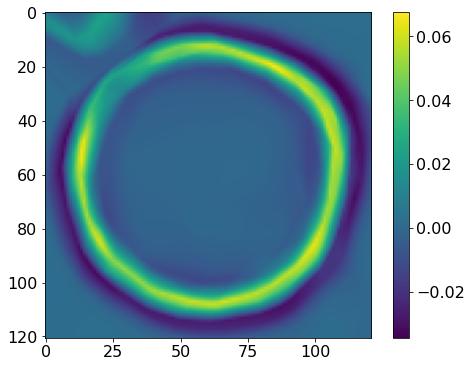

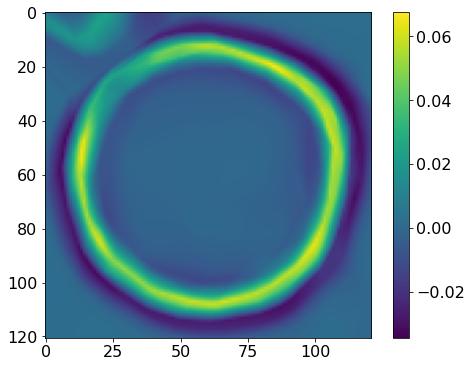

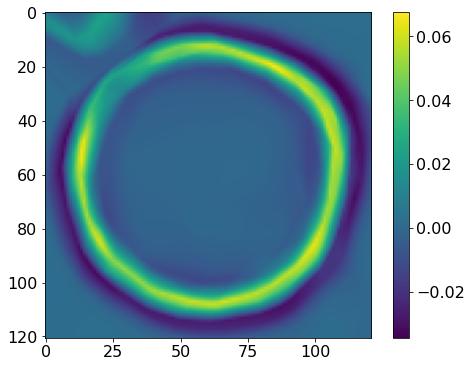

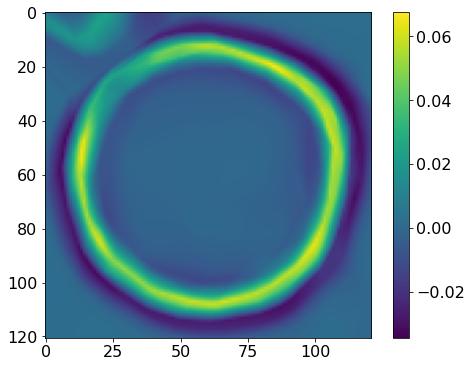

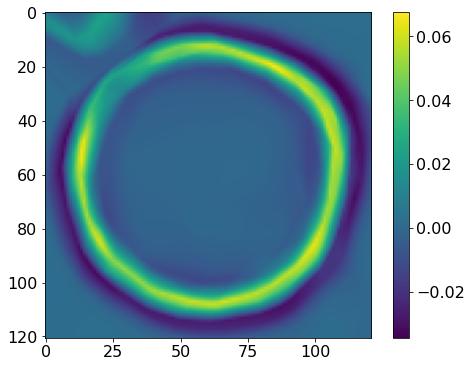

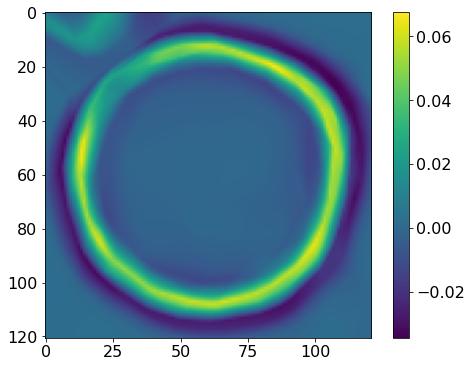

In [10]:
upred=np.zeros(u.shape)

for x_, y_, t_, u_ in train_dataset:
    t_=t_/t_*0.35
    plt.show()
    #plt.imshow(u_.numpy().reshape(121,121))
    #plt.colorbar()
    #plt.show()
    p_=nn_model(tf.reshape(tf.concat([x_,y_,t_],1),(-1,3)))
    plt.imshow(p_.numpy().reshape(121,121))
    plt.colorbar()
    plt.show()
    #plt.imshow(p_.numpy().reshape(121,121)-u_.numpy().reshape(121,121))
    #plt.colorbar()
    #plt.show()


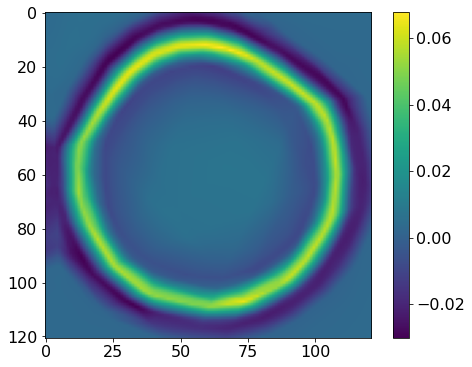

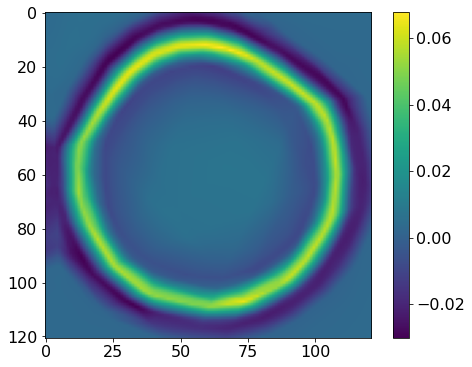

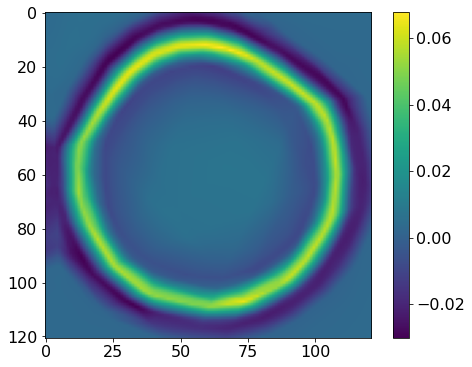

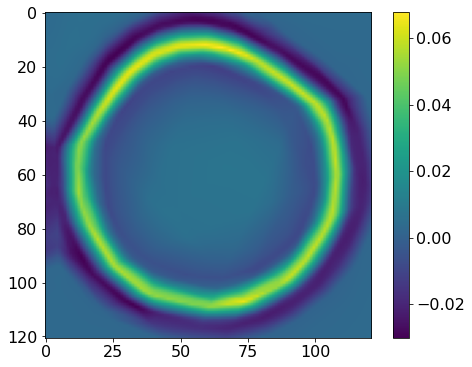

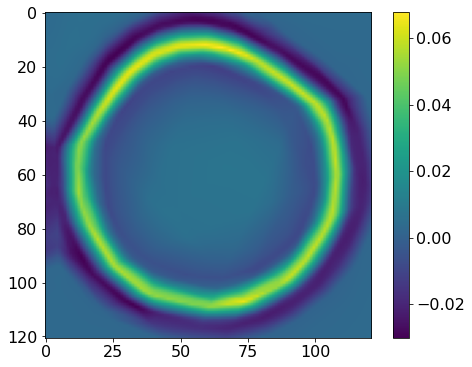

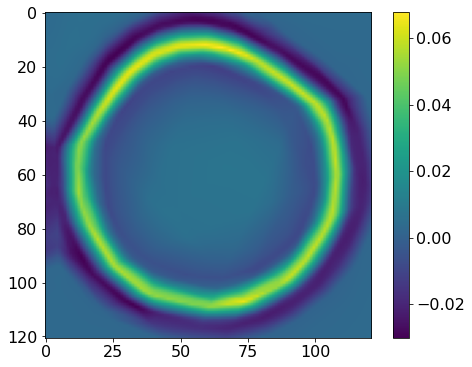

In [12]:
upred=np.zeros(u.shape)

for x_, y_, t_, u_ in train_dataset:
    t_=t_/t_*0.35
    plt.show()
    #plt.imshow(u_.numpy().reshape(121,121))
    #plt.colorbar()
    #plt.show()
    p_=nn_model(tf.reshape(tf.concat([x_,y_,t_],1),(-1,3)))
    plt.imshow(p_.numpy().reshape(121,121))
    plt.colorbar()
    plt.show()
    #plt.imshow(p_.numpy().reshape(121,121)-u_.numpy().reshape(121,121))
    #plt.colorbar()
    #plt.show()
